In [1]:
import pdb
import numpy as np
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import pylab as plt
from astropy.wcs import WCS
from astropy.io import fits
import readcol
from utils import shift_twod
from utils import dist_idl
from utils import loggen
from utils import gauss_kern
from lmfit import Parameters, minimize, fit_report
from sedstack import stack_libraries_in_redshift_slices
from skymaps import Skymaps
from skymaps import Field_catalogs

%matplotlib inline  

In [2]:
popcolor=['blue','red','green','orange','black','grey','chocolate','darkviolet','pink',
          'magenta','dodgerblue','lavender','blue','red','green','orange','black','grey',
          'chocolate','darkviolet','pink','magenta','dodgerblue','lavender']

In [3]:
#Define Redshift Bins
z_lo = np.array([0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5])
z_hi = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_nodes = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
z_mid = (z_nodes[:-1] + z_nodes[1:])/2
nz = len(z_nodes) - 1

In [4]:
#Define Stellar Mass Bins
m_lo = np.array([8.5, 9.5,10.0,10.5,11.0])
m_hi = np.array([9.5,10.0,10.5,11.0,13.0])
m_nodes = np.array([8.5, 9.5,10.0,10.5,11.0,13.0])
m_mid = (m_nodes[:-1] + m_nodes[1:])/2
nm = len(m_nodes) - 1

In [5]:
#Decide which Maps to include
wv0 = np.array([1,1,1,1,1,1,1,1,1]) # This includes all maps
wv0 = np.array([0,1,1,1,1,0,1,0,0]) # This one only includes PACS and SPIRE
wv0 = np.array([0,0,1,1,0,0,1,0,0]) # This one only includes PACS RED and SPIRE 250, 500
indstack = np.where(wv0 == 1)

In [6]:
# Map Directories 

dir_spitzer_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_spire_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_pacs_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_scuba_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'
dir_aztec_maps = '/Users/marco/Code/Python/Modules/simstack/data/cutouts/'

## Dictionary Names
library_keys =['mips24'
               ,'pacs_green'
               ,'pacs_red'
               ,'spire_PSW'
               ,'spire_PMW'
               ,'scuba_450'
               ,'spire_PLW'
               ,'scuba_850'
               ,'aztec'
              ]

wavelength=[24.,100,160,250,350,450,500,850,1100]
nwv = np.sum(wv0) 
fwhm =[6.32,7.4, 11.3,18.1, 25.2,7., 36.6,15.,18.]
efwhm=[6.32,6.7, 11.2,17.6, 23.9,7.8, 35.2,14.5,18.] # want to the measured effective FWHM later
color_correction=[1.25,23.58,23.82,1.018,0.9914,1.0,0.95615,1.0,1.0]
beam_area = [1.55e-09,1.,1.,1.,1.,1.62e-09,1.,5.6e-09,1.] #sr

pixsize_suffix = '5.0_arcsec_pixels'

maps = [dir_spitzer_maps+'mips_24_GO3_sci_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.sci.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.sci.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.signal.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.signal.cutout.fits'
        ,dir_scuba_maps+'map450_new_header.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.signal.cutout.fits'
        ,dir_scuba_maps+'map850_new_header.cutout.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_map.cutout.fits'
       ]
noises = [dir_spitzer_maps+'mips_24_GO3_unc_10.cutout.fits' 
        ,dir_pacs_maps+'pep_COSMOS_green_Map.DR1.err.cutout.fits'
        ,dir_pacs_maps+'pep_COSMOS_red_Map.DR1.err.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PSW.noise.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PMW.noise.cutout.fits'
        ,dir_scuba_maps+'map450_new_header_rms.cutout.fits'
        ,dir_spire_maps+'cosmos-uvista-hipe12_itermap_10_iterations_'+pixsize_suffix+'_PLW.noise.cutout.fits'
        ,dir_scuba_maps+'map850_new_header_rms.cutout.fits'
        ,dir_aztec_maps+'cosmos_jcmt_kscott20100925_noise.cutout.fits'
       ]

In [7]:
sky_library_gaussians={}
#sky_library_psfs={}

for t in indstack[0]:
    sky_library_gaussians[library_keys[t]] = Skymaps(maps[t],noises[t],efwhm[t],color_correction=color_correction[t])
    #sky_library_psfs[library_keys[t]] = Skymaps(maps[t],noises[t],sedstackbeams[t],color_correction=color_correction[t])
    sky_library_gaussians[library_keys[t]].add_wavelength(wavelength[t])
    sky_library_gaussians[library_keys[t]].add_fwhm(efwhm[t])    
    #sky_library_psfs[library_keys[t]].add_wavelength(wavelength[t])
    #sky_library_psfs[library_keys[t]].add_fwhm(efwhm[t])

In [8]:
path_catalog = '/data/maps_cats_models/catalogs/UVISTA/'
file_catalog = 'UVISTA_final_v4.1_zCOSMOS_zEAZY_RFcolors_IDs_mass_AGN_SFRs_parentids.csv'

In [9]:
tbl = pd.read_table(path_catalog+file_catalog,sep=',')

In [10]:
uVista = Field_catalogs(tbl)

In [11]:
# This function creates a column 'sfg', where sf == 1 and qt == 0
uVista.separate_sf_qt()

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


/Users/marco/Code/Python/Modules/simstack/sedstack.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  model[cuLL[iwv]:cuLL[iwv+1]] +=  fluxes[0][iwv] * layers_1d[ cuSuperChunk[iwv] + i * LenLayers[iwv]: cuSuperChunk[iwv] + (i+1) * LenLayers[iwv] ]


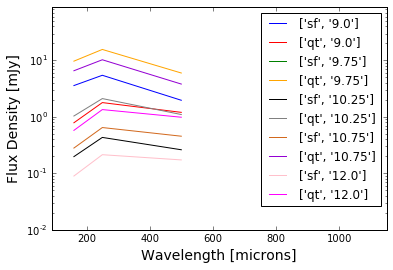

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


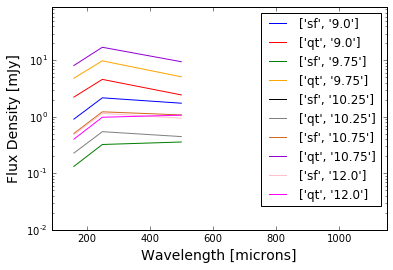

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


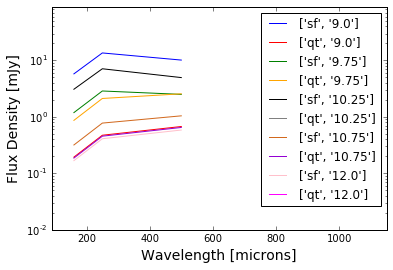

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


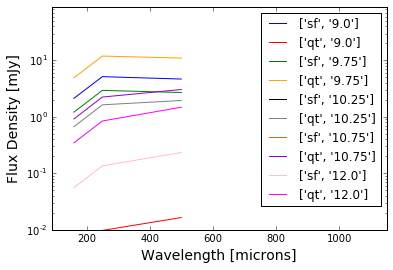

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


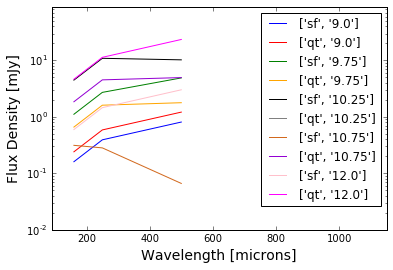

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


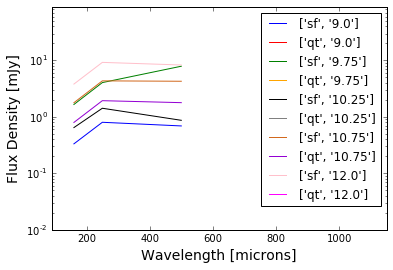

spire_PSW
pacs_red
spire_PLW
250 cube smoothed
160 cube smoothed
500 cube smoothed


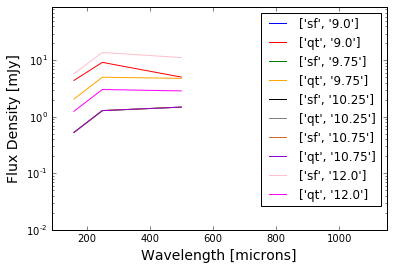

In [12]:
#Stack by Z, M, SF/QT
#WARNING, NEED TO ADD Z BINS TO THIS
pop = ['sf','qt']
npop=2
all_stacked_fluxes_gaussians = np.zeros([nwv,nz,nm,npop])
all_luminosity_temp_gaussians= np.zeros([nz,nm,npop,2])

for iz in range(nz):
    zn = z_nodes[iz:iz+2]
    uVista.get_sf_qt_mass_redshift_bins(zn,m_nodes)
    radec_m_z_p = uVista.subset_positions(uVista.id_z_ms)
    stacked_fluxes_gaussians =  None
    n_sources_max = None
    
    [stacked_fluxes_gaussians,v] = stack_libraries_in_redshift_slices(
        sky_library_gaussians,
        radec_m_z_p,zed=np.mean(zn))
    
    #PLOT
    plt.ylim([-1e-1,3e0])
    plt.ylim([1e-2,9e1])
    plt.xlim([90,510])
    plt.xlim([90,1150])
    plt.yscale('log')
    plt.ylabel('Flux Density [mJy]',fontsize=14)
    plt.xlabel('Wavelength [microns]',fontsize=14)
    for j in range(nm): 
        for k in range(npop):
            all_stacked_fluxes_gaussians[:,iz,j,k]= stacked_fluxes_gaussians[:,npop*j+k]
            all_luminosity_temp_gaussians[iz,j,k,:] = np.asarray([v['L'+str(npop*j+k)],v['T'+str(npop*j+k)]])
            plt.plot(np.array(wavelength)[indstack],1e3*stacked_fluxes_gaussians[:,npop*j+k],color=popcolor[npop*j+k],label=[pop[k],str(m_mid[j])])
            plt.legend()
        
    plt.show()

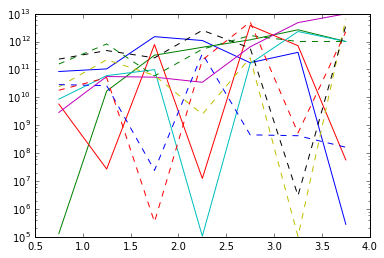

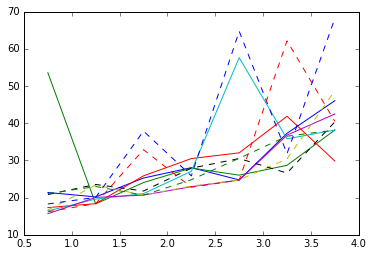

In [30]:
ln=['','--']
for k in range(npop):
    for j in range(nm):
        plt.yscale('log')
        plt.plot(z_mid,all_luminosity_temp_gaussians[:,j,k,0],ln[k])
plt.show()
for k in range(npop):
    for j in range(nm):
        plt.plot(z_mid,all_luminosity_temp_gaussians[:,j,k,1],ln[k])
plt.show()